In [3]:
import numpy as np
from matplotlib import pyplot as plt

## First we study Steepest Descent

In [52]:
# Sample problem, Symmetric Positive Definite Matrix
A = np.array([[3,2],[2,6]])
b = np.array([2,-8])
c = 0

### Linear Equation 
$$ \mathbf{A} \vec{x} = \vec{b} $$ 

### Quadratic Form
$$ f(x) = \frac{1}{2} \vec{x}^T\mathbf{A}\vec{x} - \vec{b}^T\vec{x} + c$$

If $\mathbf{A}$ is PSD then $f(\vec{x})$ is paraboloid and it is minimized by the solution to $\mathbf{A}\vec{x}=\vec{b}$

### Gradients, Directions, 
$$ f'(x) = \frac{1}{2} A^Tx + \frac{1}{2} A x - b$$
If A is symmetric, then
$$f'(x) = Ax - b \quad \quad f(p) = f(x) + \frac{1}{2}(p-x)^T.A.(p-x)$$

In [8]:
def quadratic_form(x, y, A,b,c):
    # Create the vector [x, y] and calculate the quadratic form
    vec = np.array([x, y])
    return 0.5*vec.T @ A @ vec - b.T @ vec + c

def gradient_quadratic_form(x,y,A):
    vec = np.array([x,y])
    return A @ vec


In [9]:
# generate a grid of points like [[x1,y1],[x2,y2],[x3,y3]] and evalue f at each point
x = np.linspace(-5,5,27)
y = np.linspace(-5,5,27)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = quadratic_form(X[i, j], Y[i, j], A,b,c)

# Gradients
dZdx,dZdy = np.gradient(Z,x,y)

print(X.shape,Y.shape,Z.shape,dZdx.shape,dZdy.shape)

(27, 27) (27, 27) (27, 27) (27, 27) (27, 27)


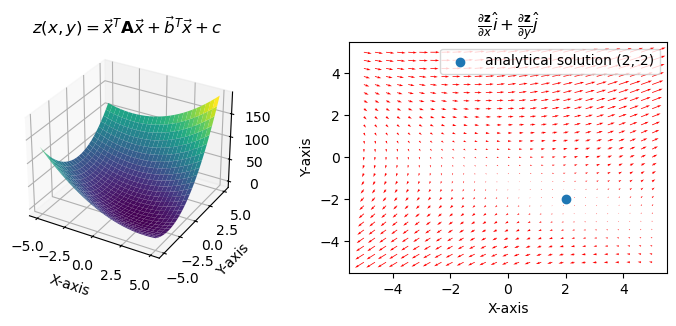

In [10]:
fig = plt.figure(figsize=(9, 3))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_title('$z(x,y) = \\vec{x}^T \\mathbf{A} \\vec{x} + \\vec{b}^T \\vec{x} + c$')

ax2 = fig.add_subplot(122)
ax2.quiver(X, Y, dZdx, dZdy, angles='xy', scale_units='xy', scale=100, color='r')
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
ax2.set_title("$\\frac{\\partial \\mathbf{z}}{\\partial x}\\hat{i} + \\frac{\\partial \\mathbf{z}}{\\partial y}\\hat{j}$")
plt.scatter([2],[-2],label="analytical solution (2,-2)")

plt.legend()
plt.show()

I'm trying to plot the normal-plane slicing this surface at a specific point $\vec{x}_p$ \
The normal-plane must lie along the gradient vector $\vec{g}_p = \mathbf{A}\vec{x}_p + \vec{b} = \frac{\partial z(x,y)}{\partial x} \hat{i} + \frac{\partial z(x,y)}{\partial y} \hat{j} $ \
Once you know the gradient $\vec{g}_p$ at point $\vec{x}_p$, you can evaluate the normal-vector $\vec{n}_p = \frac{\partial z(x,y)}{\partial x} \vert_{x_p} \hat{i} + \frac{\partial z(x,y)}{\partial y} \vert_{y_p} \hat{j} -\hat{k}$ because the gradient is normal to the surface. \
Now that we know the normal at the point, we need to find another vector that also lies on the normal-plane so that we have the complete span for the normal-plane and we can construct the normal-plane.
The tangent plane is given by $z = z_p + \frac{\partial z}{\partial x}\vert_{x_p} (x-x_p) + \frac{\partial z}{\partial y} \vert_{y_p}(y-y_p)$

the gradient vector is tangent to the surface 
the normal vector is perpendicular to this gradient vector

given the surface f(x,y) = z 
now consider another surface F(x,y) = f(x,y) - z = 0
The gradient of the F surface is normal to the f surface



In [ ]:
xp, yp = 1, 2
zp = quadratic_form(xp, yp, A,b,c)
gp = gradient_quadratic_form(xp, yp, A)
dfdx, dfdy = gp

# plotting the tangent plane to the surface at (x,y) = (1,2)
# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate d and we're set
point = np.array([xp,yp,zp])
normal = np.array([dfdx,dfdy,-1])
d = -point.dot(normal)
# c = -1, so a*x + b*y -z + d = 0 or z = a*x + b*y + d
z_tangent = -(normal[0] * X + normal[1] * Y + d)

# normal surface
xx = np.linspace(xp - 0.5*dfdx, xp + 0.5*dfdx,10)
yy = np.linspace(yp - 0.5*dfdx, yp + 0.5*dfdy,10)
XX, YY = np.meshgrid(xx,yy)
z_normal = (dfdx * XX + dfdy * YY) + d

In [ ]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, Z, cmap='viridis',alpha=0.5)
ax.plot_surface(X,Y, z_tangent,alpha=0.5)
ax.plot_surface(XX,YY, z_normal,alpha=0.5)
# ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.3, color='red', edgecolor='k')

# Plot the point (1, 2, f(1,2))
ax.scatter(xp, yp, zp, color='black', s=50, label='Point (1,2) on surface')


# Add labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(X, Y)')

ax.set_title('$z(x,y) = \\vec{x}^T \\mathbf{A} \\vec{x} + \\vec{b}^T \\vec{x} + c$')


The goal is to find a sequence of steps $x^{(1)},x^{(2)},...x^{(n)}$ that converge to the minima of the bowl \
\begin{equation}
\begin{split}
-\vec{f'}(\vec{x}^{(i)}) &= \vec{b} - \mathbf{A} \vec{x}^{(i)} \quad \quad \text{Direction of each step, negative of the gradient} \\
\vec{e}^{(i)} &= \vec{x}^{(i)} - \vec{x} \quad \quad \text{Error at each step, difference between "true" x and computed} \\
\vec{r}^{(i)} &= \vec{b} - \mathbf{A}\vec{x}^{(i)} \quad \quad \text{Residual at each step, difference between "true" b and computed } \\
\vec{r^{(i)}} &= \mathbf{A}\vec{e^{(i)}} = \vec{f'}(\vec{x}^{(i)})
\end{split}
\end{equation}
You could think of the Residual as a tranformation of $\vec{e}$ into $\vec{b}$ and it's equal to the "direction of steepest descent" 
$$ \therefore \vec{x}^{(i+1)} = \vec{x}^{(i)} + \alpha \vec{r}^{(i)}$$
$\alpha$ is the "learning rate". How do you set $\alpha$? 
For a given iteration, $\vec{x}^{(i+1)}$, the step-direction is $\vec{r}^{(i)}$ and $\alpha$s is the "multiplier". The plot of $f(p + \alpha r) vs \alpha $ is obtained by taking a slice on the bowl. A plane cuts across the bowl. The plane passes through the point $p$ and is parallel to $r$. This gives a parabola. \
$\alpha$ minimizes $\vec{f}$ when the derivative $\partial f/\partial \alpha = 0$ \
By taking the chain rule we get 
$$ \frac{\partial \vec{f}(\vec{x^{(i+1)}})}{\partial \alpha} = \frac{\partial \vec{f}(\vec{x}^{(i+1)})}{\partial \vec{x}^{(i+1)}} \frac{\partial \vec{x}^{(i+1)}}{\partial \alpha} = \frac{\partial \vec{f}(\vec{x}^{(i+1)})}{\partial \vec{x}^{(i+1)}} \vec{r}^{(i)}$$

Therefore to minimize $\vec{f}(\vec{x}^{(i+1)})$ we need to choose $\alpha$ such that $\vec{r}^{(i)}$ and the gradient $\vec{f}'(\vec{x}^{(i+1)})$ are orthogonal



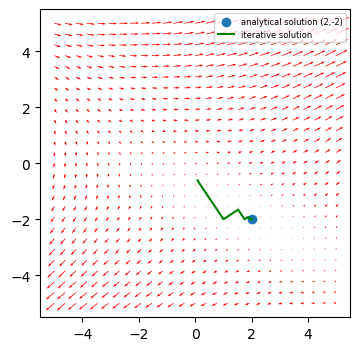

In [48]:
# you need to  copute this for every step
def iAlpha(r_curr, A):
    num = r_curr @ r_curr
    den = r_curr @ A @ r_curr
    return num/den

# you need to use this occasionally to make sure you have the correct residue and wash away any accumulated floatig point errors in xi
def iResidueTrue(b,A,x_curr):
    return (b - A @ x_curr)

# this is faster to compute but it will accumulate floating point errors
def iResidueRecursive(r_prev, a_prev, A):
    return r_prev - a_prev * A @ r_prev


# you start at x0,
# compute r0 using TrueResidue(b,A,x0)
# compute a0 using iAlpha(r0,A)
# now you have x0, r0, a0 
# now compute r1 using RecursiveResidue(r0,a0,A)
# now compute a1 using iAlpha(r1,A)
# now you have r1,a1 - so you can use that to compute r2,a2
# and after 2 steps compute ri using TrueResidue
# terminate when xi and xi-1 differ by 1e-6

def steepest_descent(A, b, x0, tol=1e-8, max_iter=500):
    x = x0.copy()
    r = iResidueTrue(b,A,x) 
    res_norm = []
    x_arr = []
    
    for k in range(max_iter):
        alpha = iAlpha(r,A)
        x = x + alpha * r
        r = iResidueTrue(b,A,x)
        x_arr.append(x)
        res_norm.append(np.linalg.norm(r))
        if res_norm[-1] < tol:
            break

    return np.array(x_arr), np.array(res_norm)

x_arr,resNorm = steepest_descent(A, b, np.array([-2,-2]))
fig = plt.figure(figsize=(4,4))

plt.quiver(X, Y, dZdx, dZdy, angles='xy', scale_units='xy', scale=100, color='r')
plt.scatter([2],[-2],label="analytical solution (2,-2)")
plt.plot(x_arr[:,0],x_arr[:,1],label='iterative solution',color='green')
plt.legend(fontsize=6)
plt.show()

## Steepest Descent applied to 1D Poisson Equation
$$ -u''(x) = f(x) ; x \in (0,1) $$

with `DBC` $u(0) = u(1) = 0$

The known analytical solution is $u(x) = sin(\pi x)$ and $f(x) = \pi^2 sin(\pi x) $

discretize it into step-size $h = 1/N$ parts
$$ - \frac{u_{i-1} - 2u_i + u_{i+1}}{h^2} = f_i$$ 

Or, in matrix form $ \mathbf{A} \vec{u} = \vec{f}$  where 

$$ \vec{u} = [u_1, u_2, ... u_{N-2}]$$ 
$$ \mathbf{A} = \frac{1}{h^2} \begin{bmatrix} 
 2  & -1 & 0 & 0 & ... & 0 \\
-1  &  2 & -1 & 0 & ... & 0 \\
 0  & -1 & 2 & -1 & ... & 0 \\
 0  &  0 & -1 & 2 & ... & 0 \\
 ... & ... & ... \\ 
 0  &  0 & 0 & ... & -1 & 2 \\
\end{bmatrix} $$
This $\mathbf{A}$ is only the interior of the matrix. We're assuming DBC

In [12]:
# utility function to generate the Poisson Matrix - but only the interior of it. assuming DBC
def generate_1D_poisson_matrix(N):
    main_diag = 2 * np.ones(N-2) # N-2 because DBC
    off_diag = -1 * np.ones(N-3)
    A = (np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1))
    return A
    # remember to multiply by N^2

# Syntax explanation - This returns a 2X2 matrix [[1,2] [5,1]]
# np.diag([1,1]) + np.diag([2], k=1) + np.diag([5], k=-1)

# N = 6 retuns a 4X4 matrix because of DBC
print(generate_1D_poisson_matrix(6))

[[ 2. -1.  0.  0.]
 [-1.  2. -1.  0.]
 [ 0. -1.  2. -1.]
 [ 0.  0. -1.  2.]]


res-norm = 10.260410230217506 ,|u_exact - uk| = 0.567568504563355


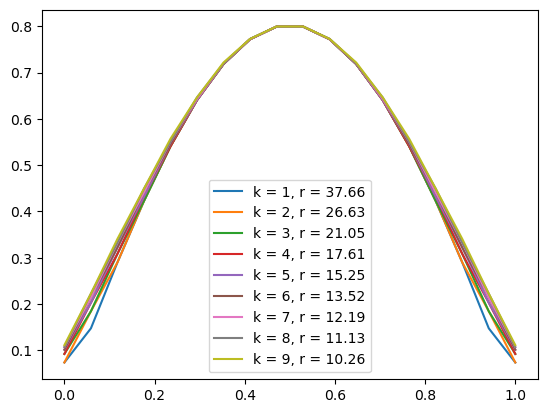

In [49]:
N = 20
xg = np.linspace(0,1,N-2)
A = (N-1)**2 * generate_1D_poisson_matrix(N)
# A = np.pad(A, pad_width=1, mode='constant', constant_values=0) # pad with 0 for DBC
f_exact = np.pi**2 * np.sin(np.pi * xg)
f_exact[0] = 0
f_exact[-1] = 0

initialGuess = np.zeros(N-2) 
u_arr,res_arr = steepest_descent(A,f_exact,initialGuess,1e-2,10)

u_exact = np.sin(np.pi * xg) # for checking our answer
u_exact[0] = 0
u_exact[-1] = 0

print(f"res-norm = {res_arr[-1]} ,|u_exact - uk| = {np.sqrt(np.dot(u_exact - u_arr[-1],u_exact - u_arr[-1]))}")

for k in range(1,len(u_arr)):
    plt.plot(xg,u_arr[k],label=f"k = {k}, r = {res_arr[k]:.2f}")

plt.legend()
plt.show()

### Pre-Conditioned Steepest Descent

In [64]:
import numpy as np

def precond_steepest_descent(A, b, M_inv, x0, tol=1e-8, max_iter=500):
    x = x0.copy()
    r = b - A @ x
    res_norm = []
    x_arr = []
    
    for k in range(max_iter):
        z = M_inv @ r  # preconditioned residual
        alpha = (r @ z) / (z @ (A @ z))
        x = x + alpha * z
        r = r - alpha * (A @ z)
        res_norm.append(np.linalg.norm(r))
        x_arr.append(x)
        if res_norm[-1] < tol:
            break
    return np.array(x_arr), np.array(res_norm)

# Sample problem, Symmetric Positive Definite Matrix
A = np.array([[3,2],[2,6]])
b = np.array([2,-8])
c = 0
x0 = np.array([-10,10])

M_inv = np.diag(1/np.diag(A))   # simple diagonal preconditioner

x_arr_psd, res_arr_psd = precond_steepest_descent(A,b,M_inv,x0)


In [65]:
res_arr_psd

array([1.97715484e+01, 7.29138679e+00, 2.91370187e+00, 1.07452016e+00,
       4.29387645e-01, 1.58350339e-01, 6.32781792e-02, 2.33358395e-02,
       9.32520536e-03, 3.43896581e-03, 1.37424079e-03, 5.06794962e-04,
       2.02519695e-04, 7.46855734e-05, 2.98450077e-05, 1.10062950e-05,
       4.39821167e-06, 1.62198032e-06, 6.48157509e-07, 2.39028679e-07,
       9.55179486e-08, 3.52252790e-08, 1.40763293e-08, 5.19109374e-09])

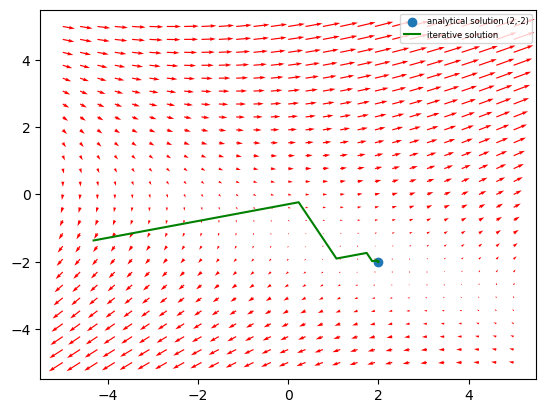

In [66]:
plt.quiver(X, Y, dZdx, dZdy, angles='xy', scale_units='xy', scale=100, color='r')
plt.scatter([2],[-2],label="analytical solution (2,-2)")
plt.plot(x_arr_psd[:,0],x_arr_psd[:,1],label='iterative solution',color='green')
plt.legend(fontsize=6)
plt.show()

## Conjugate Gradient

$$ \vec{u}^{(k+1)} = \vec{u}^{(k)} + \alpha^{(k)} \vec{d}^{(k)} $$
$$ \alpha^{(k)} = - \frac{\langle \vec{g}^{(k)} , \vec{d}^{(k)} \rangle}{\langle \vec{g}^{(k)},  \vec{d}^{(k)} \rangle_A} $$
$$ \vec{d}^{(k+1)} = - \vec{g}^{(k+1)} + \beta^{(k)} \vec{d}^{(k)}$$ 
$$ \beta^{(k)} = - \frac{\langle \vec{g}^{(k+1)} , \vec{d}^{(k)} \rangle_A}{\langle \vec{d}^{(k)},  \vec{d}^{(k)} \rangle_A} $$

- $\vec{d}$ is the direction for the next step
- $\vec{g}$ is the gradient of the bowl
- $\beta$ is a memory of the previous direction
- $\vec{d}^{(0)} = - \vec{g}^{(0)} = \vec{f} - \mathbf{A}\vec{u}^{(0)}$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def poisson_matrix_1D(N):
    """Construct SPD tridiagonal matrix for 1D Poisson."""
    h = 1.0 / (N - 1)
    main_diag = 2.0 * np.ones(N - 2)
    off_diag = -1.0 * np.ones(N - 3)
    A = (1.0 / h**2) * (
        np.diag(main_diag) +
        np.diag(off_diag, k=1) +
        np.diag(off_diag, k=-1)
    )
    return A

def conjugate_gradient(A, b, tol=1e-10, max_iter=1000):
    """Manual implementation of the Conjugate Gradient algorithm."""
    x = np.zeros_like(b)
    r = b - A @ x
    p = r.copy()
    rs_old = np.dot(r, r)

    for k in range(max_iter):
        Ap = A @ p
        alpha = rs_old / np.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap
        rs_new = np.dot(r, r)
        if np.sqrt(rs_new) < tol:
            print(f"Converged in {k+1} iterations, residual = {np.sqrt(rs_new):.2e}")
            break
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new
    return x

# Parameters
N = 20
x = np.linspace(0, 1, N)
h = 1.0 / (N - 1)

# Build A and f
A = poisson_matrix_1D(N)
f = np.sin(np.pi * x[1:-1])   # interior points only
b = f                         # right-hand side (no scaling needed)

# Solve with CG
u_interior = conjugate_gradient(A, b)

# Add Dirichlet boundary conditions
u = np.zeros_like(x)
u[1:-1] = u_interior

# Exact solution
u_exact = np.sin(np.pi * x) / (np.pi**2)

# Plot
plt.plot(x, u, 'o-', label='CG solution')
plt.plot(x, u_exact, '--', label='Exact solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('1D Poisson equation solved with Conjugate Gradient')
plt.show()
